In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import seaborn as sns
from scipy.stats import norm
%matplotlib notebook
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

## Create a hitmap that is 20*20

In [2]:
def get_gaussian_weights(value, stds, cutoff=False):
    
    '''
    return the weights for the time, longitude, and latitude for interpolation
    Uses the Gaussian distribution 
    
    param: values = list with [longitude, latitude, time] of that point
    param: stds = list with custom stds for [time, lon, lat]
    '''
    
    lon, lat, time = tuple(value)
    lon_std, lat_std, time_std = tuple(stds)
    
    z_lon = (df['Lon'] - lon) / lon_std
    z_lat = (df['Lat'] - lat) / lat_std
    z_time = (df['secDay'] - time) / time_std
    
    # If cutoff is specified, returns np.nan for values greater than 3 standard deviations away for lats and lons
    
    three_deviations = 1.96
    if cutoff:
        z_lon = np.where(abs(z_lon) > three_deviations, np.nan, z_lon)
        z_lat = np.where(abs(z_lat) > three_deviations, np.nan, z_lat)
        z_time = np.where(abs(z_time) > three_deviations, np.nan, z_time)
    
    # finds the weights
    w_lon = norm.pdf(z_lon)
    w_lat = norm.pdf(z_lat)
    w_time = norm.pdf(z_time)
    
    return w_lon, w_lat, w_time

In [3]:
def get_data_for_heatmap(lons, lats, time, dists, heatmap_size, col_name='sw pCO2 (uatm)', 
                         time_factor=1, size_factor=1, cutoff=False):
    '''
    If cutoff is specified, returns np.nan for values greater than 3 standard deviations away for lats and lons
    '''
    
    dist_lon, dist_lat, dist_time = tuple(dists) 
    stds=[dist_lon * size_factor, dist_lat * size_factor, dist_time * time_factor]

    data = np.zeros((heatmap_size, heatmap_size))
    for i, lat in enumerate(lats):
        
        data_arr = []
        
        for lon in lons:
            w_lon, w_lat, w_time = get_gaussian_weights((lon, lat, time), stds=stds, cutoff=cutoff)
            
            X = df[col_name].values
            
            # checks if the weights have nan values, which will turn the val to nan
            if np.isnan(w_lon).any() or np.isnan(w_lat).any() or np.isnan(w_time).any():
                val = np.nan
            else:            
                val = np.sum(X * w_time * w_lon * w_lat) / np.sum(w_time * w_lon * w_lat)  
                
            data_arr.append(val)
        
        data[i, :] = data_arr
        
    return data

# Displaying timeseries heatmap

In [4]:
df = pd.read_csv('FLO_L3_20170317.csv', skiprows=[1])

# filters out all the values that are -9999
df.replace(-9999, np.NaN, inplace=True)
df = df[['Lat', 'Lon', 'secDay', 'Water temp (C)', 'Salinity (PSU)', 'O2 umol/L', 'Chl a (mg/m3)', 'sw pCO2 (uatm)']]
df.dropna(inplace=True)

# sets bounds for longitude
# df = df[df['Lon'] > -70.155]

heatmap_size = 30
# np.linspace(0, 7, 14, endpoint=False)[1::2]
time_size = 12

# to change the standard deviations
size_factor = 1
time_factor = 1

# calculates the distance of each box of the heatmap in lat/lon units
dist_lon = (df['Lon'].max() - df['Lon'].min()) / heatmap_size
dist_lat = (df['Lat'].max() - df['Lat'].min()) / heatmap_size
dist_time = (df['secDay'].max() - df['secDay'].min()) / time_size

# gets the values to interpolate from (which is the lat,lon coordinate in the middle of each box in the heatmap)
lons = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size * 2, endpoint=False)[1::2]
lats = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size * 2, endpoint=False)[1::2]
times = np.linspace(df['secDay'].min(), df['secDay'].max(), time_size * 2, endpoint=False)[1::2]



<IPython.core.display.Javascript object>


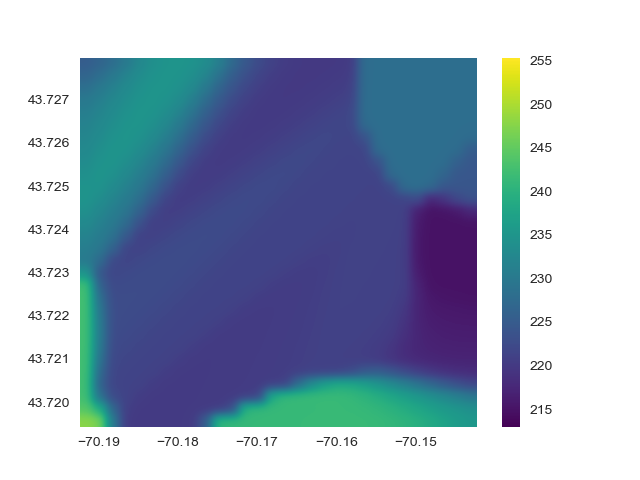

In [5]:
fig, ax = plt.subplots()
data_arr = get_data_for_heatmap(lons, lats, times[1], (dist_lon, dist_lat, dist_time), 
                                heatmap_size, time_factor=time_factor, size_factor=size_factor)
extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]
im = ax.imshow(data_arr, 
               cmap = 'viridis', 
               vmin = df['sw pCO2 (uatm)'].min(),
               vmax = df['sw pCO2 (uatm)'].max(),
               origin = 'lower',
               interpolation = 'gaussian',
               extent = extent)
ax.set_aspect('auto')

ax.grid(False)
ax.figure.colorbar(im)

In [6]:
df.columns

Index(['Lat', 'Lon', 'secDay', 'Water temp (C)', 'Salinity (PSU)', 'O2 umol/L',
       'Chl a (mg/m3)', 'sw pCO2 (uatm)'],
      dtype='object')

<IPython.core.display.Javascript object>


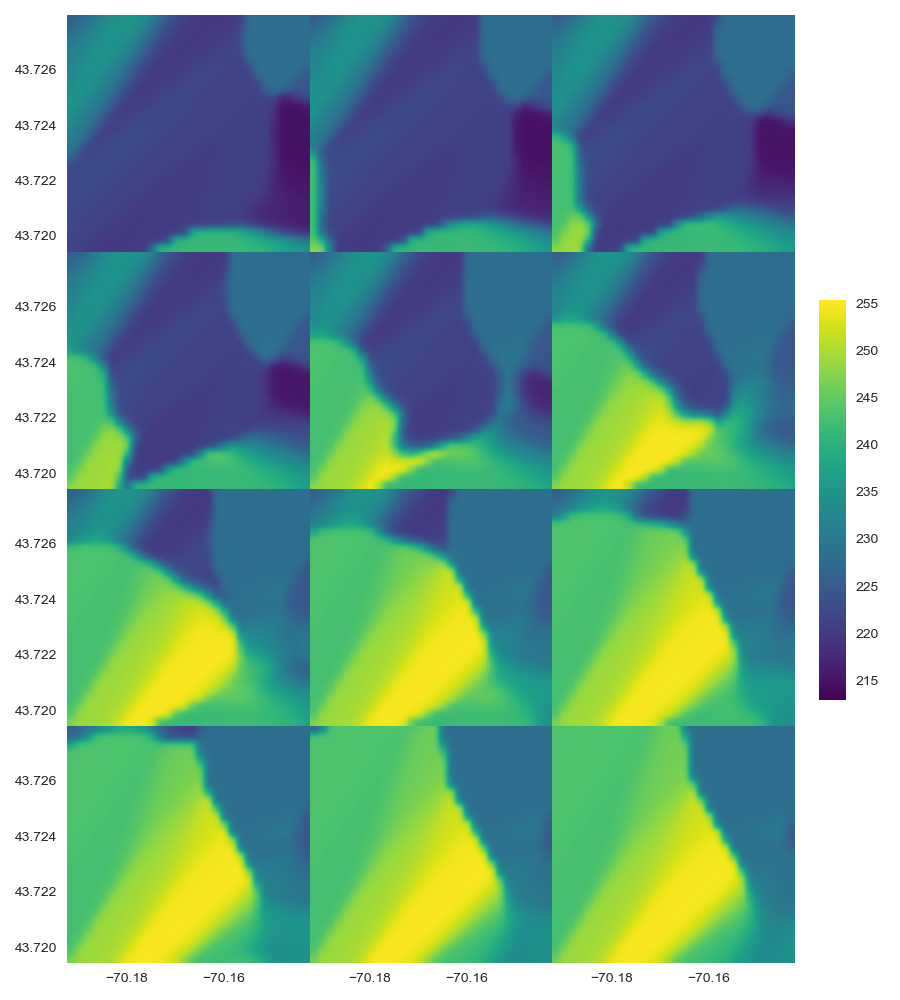

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [7]:
fig, axes = plt.subplots(4,3, figsize=(9, 10), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
# plt.subplots_adjust(wspace=0, hspace=0)

extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]
for i, ax in enumerate(axes.flat):
    data_arr = get_data_for_heatmap(lons, lats, times[i], (dist_lon, dist_lat, dist_time), 
                                    heatmap_size, time_factor=time_factor, size_factor=size_factor, 
                                    col_name='sw pCO2 (uatm)')
    im = ax.imshow(data_arr, 
                   cmap='viridis', 
                   vmin = df['sw pCO2 (uatm)'].min(),
                   vmax = df['sw pCO2 (uatm)'].max(),
                   origin='lower',
                   extent=extent,
                   interpolation='gaussian')
#     ax.set(title='time: {}'.format(i))
    ax.set_aspect('auto')
    ax.grid(False)
    
    # formats the ticks to look better
    if i == 0:
        ticks = ax.get_xticks()
        ax.set_xticks(ticks[:])
     
    # turns off scientific notation
    if i == 0:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

fig.colorbar(im, ax=axes.ravel().tolist(), cax=cbar_ax)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0, hspace=0)

In [35]:
# import matplotlib as mpl

# # creates a color array
# data = df['sw pCO2 (uatm)']
# normal = mpl.colors.Normalize()
# normal.autoscale(data)
# rgba_colors = plt.cm.jet(normal(data))

# alphas = norm.pdf(df['secDay'], times[3], dist_time / 2)
# rgba_colors[:, 3] = alphas / alphas.max()

In [36]:
# fig, ax = plt.subplots()
# data_arr = get_data_for_heatmap(lons, lats, times[3], (dist_lon, dist_lat, dist_time), 
#                                 heatmap_size, time_factor=time_factor, size_factor=size_factor)
# extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]
# im = ax.imshow(data_arr, 
#                cmap = 'Greys', 
#                vmin = df['sw pCO2 (uatm)'].min(),
#                vmax = df['sw pCO2 (uatm)'].max(),
#                origin = 'lower',
#                interpolation = 'gaussian',
#                extent = extent)
# ax.set_aspect('auto')

# ax.grid(False)
# ax.figure.colorbar(im)

# ticks = ax.get_xticks()
# ax.set_xticks(ticks[::2])

# # draws the scatterplot on top
# ax.scatter(df['Lon'], df['Lat'], c=rgba_colors, s=10)

<IPython.core.display.Javascript object>


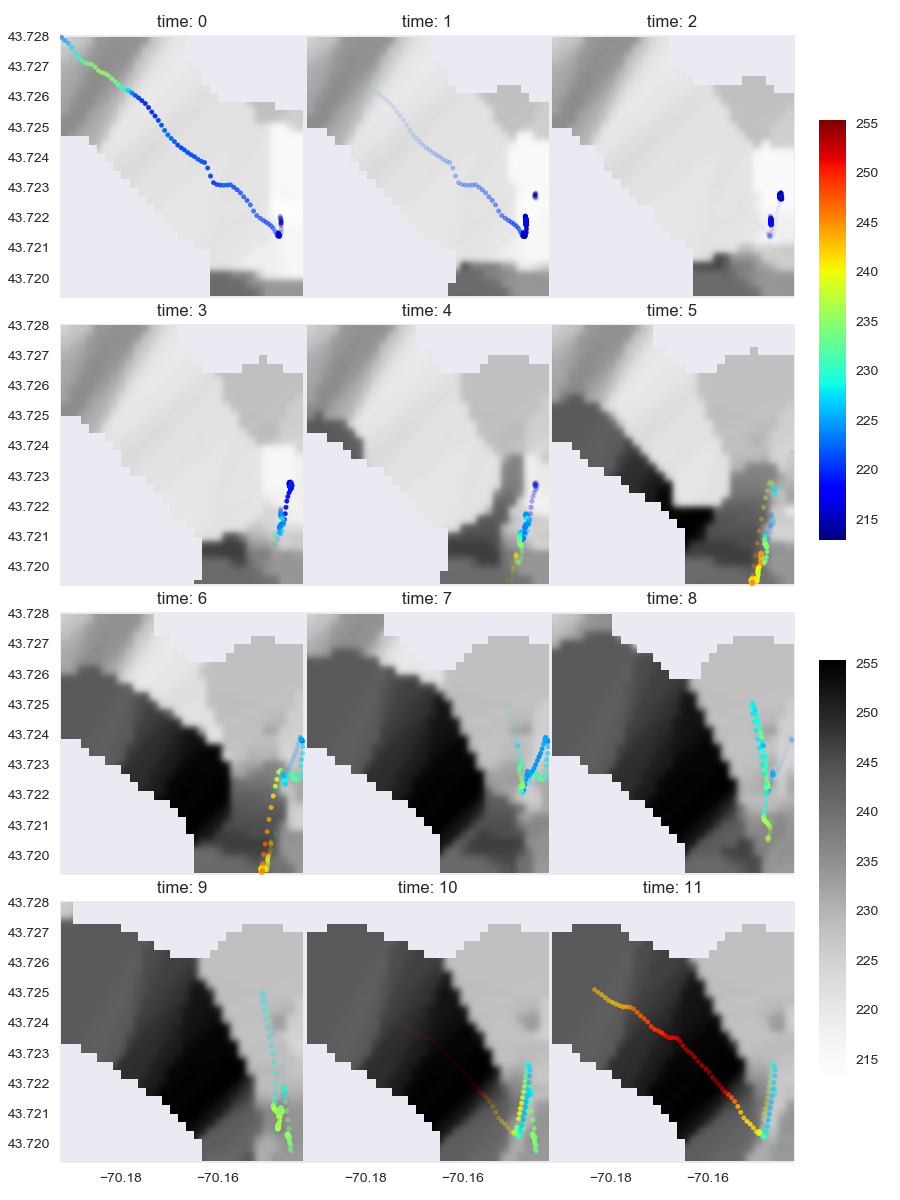

/Users/Mike/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/Mike/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [43]:
# creates a color array for jet colorscale
data = df['sw pCO2 (uatm)']
color_normal = mpl.colors.Normalize()
color_normal.autoscale(data)
cm = plt.cm.get_cmap('jet')
rgba_colors = cm(color_normal(data.values))

# sets the x and y axis to the boundaries of longitude and latitude
extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]


fig, axes = plt.subplots(4,3, figsize=(9, 12), sharex=True, sharey=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax1 = fig.add_axes([.91, .1, .03, .35])
cbar_ax2 = fig.add_axes([.91, .55, .03, .35])

for i, ax in enumerate(axes.flat):
    data_arr = get_data_for_heatmap(lons, lats, times[i], (dist_lon, dist_lat, dist_time), 
                                    heatmap_size, time_factor=time_factor, size_factor=size_factor)
    im = ax.imshow(data_arr, 
               cmap = 'Greys', 
               vmin = df['sw pCO2 (uatm)'].min(),
               vmax = df['sw pCO2 (uatm)'].max(),
               origin = 'lower',
               interpolation = 'gaussian',
               extent = extent)
    ax.set_aspect('auto')

    ax.grid(False)
    
    ax.set(title='time: {}'.format(i))
    
    alphas = norm.pdf(df['secDay'], times[i], dist_time / 2)
    rgba_colors[:, 3] = alphas / alphas.max()
    scat = ax.scatter(df['Lon'], df['Lat'], c=rgba_colors, s=10)
    
    # formats the ticks to look better
    if i == 0:
        ticks = ax.get_xticks()
        ax.set_xticks(ticks[:])
    
    
fig.colorbar(im, ax=axes.ravel().tolist(), cax=cbar_ax1)
mpl.colorbar.ColorbarBase(cbar_ax2, cmap=cm, norm=color_normal)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0, hspace=0.1)

# Zooming in the area of the kelp farm

In [38]:
# sets bounds for longitude
df = df[df['Lon'] > -70.155]

In [39]:
# reinitialize parameters

heatmap_size = 20
# np.linspace(0, 7, 14, endpoint=False)[1::2]
time_size = 12

# to change the standard deviations
size_factor = 2
time_factor = 2

# calculates the distance of each box of the heatmap in lat/lon units
dist_lon = (df['Lon'].max() - df['Lon'].min()) / heatmap_size
dist_lat = (df['Lat'].max() - df['Lat'].min()) / heatmap_size
dist_time = (df['secDay'].max() - df['secDay'].min()) / time_size

# gets the values to interpolate from (which is the lat,lon coordinate in the middle of each box in the heatmap)
lons = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size * 2, endpoint=False)[1::2]
lats = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size * 2, endpoint=False)[1::2]
times = np.linspace(df['secDay'].min(), df['secDay'].max(), time_size * 2, endpoint=False)[1::2]

<IPython.core.display.Javascript object>


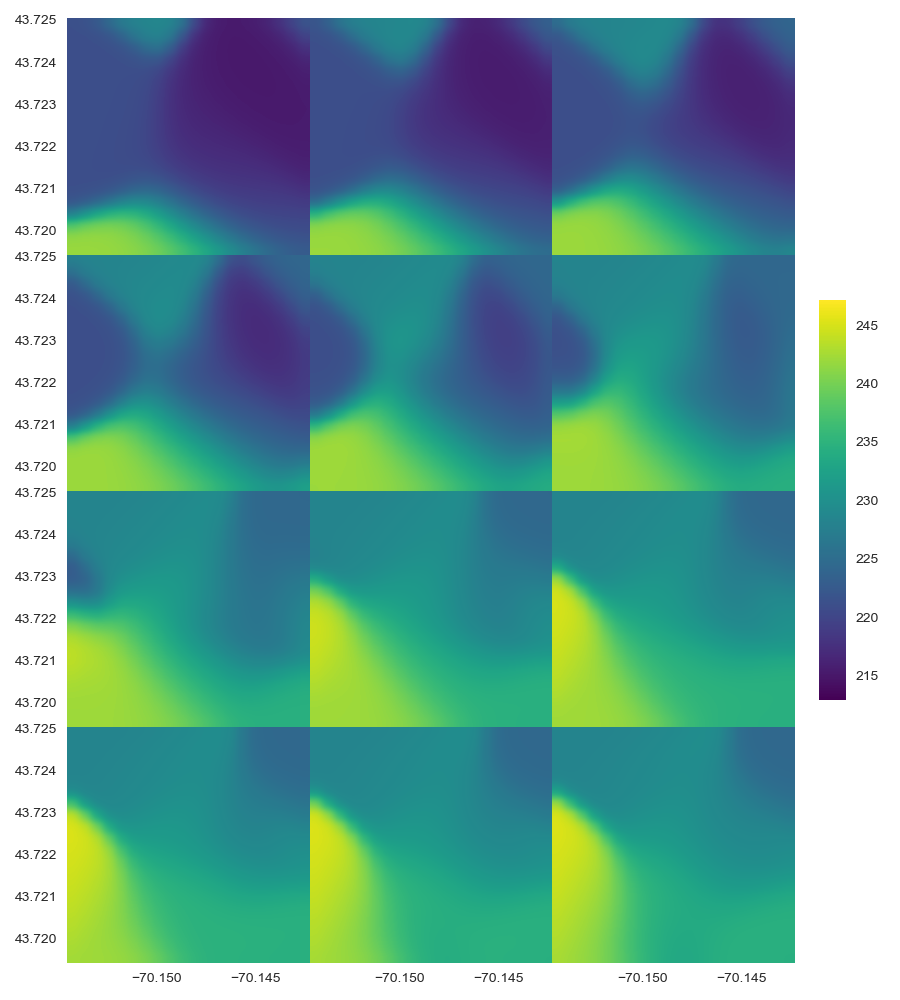

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [40]:
fig, axes = plt.subplots(4,3, figsize=(9, 10), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
# plt.subplots_adjust(wspace=0, hspace=0)

extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]
for i, ax in enumerate(axes.flat):
    data_arr = get_data_for_heatmap(lons, lats, times[i], (dist_lon, dist_lat, dist_time), 
                                    heatmap_size, time_factor=time_factor, size_factor=size_factor, 
                                    col_name='sw pCO2 (uatm)')
    im = ax.imshow(data_arr, 
                   cmap='viridis', 
                   vmin = df['sw pCO2 (uatm)'].min(),
                   vmax = df['sw pCO2 (uatm)'].max(),
                   origin='lower',
                   extent=extent,
                   interpolation='gaussian')
    
#     ax.set(title='time: {}'.format(i))
    ax.set_aspect('auto')
    ax.grid(False)
    
    # formats the ticks to look better
    if i == 0:
        ticks = ax.get_xticks()
        ax.set_xticks(ticks[:])
     
    # turns off scientific notation
    if i == 0:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

fig.colorbar(im, ax=axes.ravel().tolist(), cax=cbar_ax)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0, hspace=0)

<IPython.core.display.Javascript object>


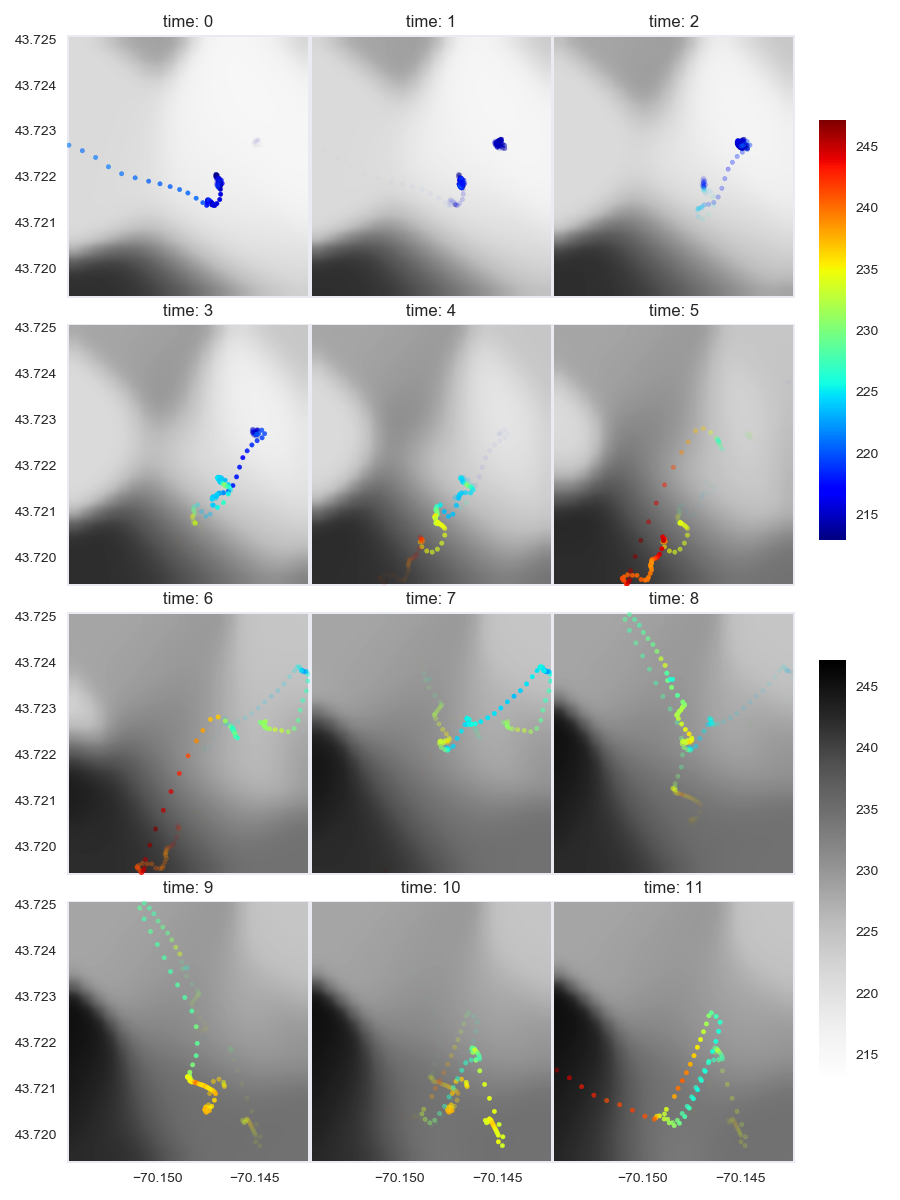

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [41]:
# creates a color array for jet colorscale
data = df['sw pCO2 (uatm)']
color_normal = mpl.colors.Normalize()
color_normal.autoscale(data)
cm = plt.cm.get_cmap('jet')
rgba_colors = cm(color_normal(data.values))

# sets the x and y axis to the boundaries of longitude and latitude
extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]


fig, axes = plt.subplots(4,3, figsize=(9, 12), sharex=True, sharey=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax1 = fig.add_axes([.91, .1, .03, .35])
cbar_ax2 = fig.add_axes([.91, .55, .03, .35])

for i, ax in enumerate(axes.flat):
    data_arr = get_data_for_heatmap(lons, lats, times[i], (dist_lon, dist_lat, dist_time), 
                                    heatmap_size, time_factor=time_factor, size_factor=size_factor)
    im = ax.imshow(data_arr, 
               cmap = 'Greys', 
               vmin = df['sw pCO2 (uatm)'].min(),
               vmax = df['sw pCO2 (uatm)'].max(),
               origin = 'lower',
               interpolation = 'gaussian',
               extent = extent)
    ax.set_aspect('auto')

    ax.grid(False)
    
    ax.set(title='time: {}'.format(i))
    
    alphas = norm.pdf(df['secDay'], times[i], dist_time / 2)
    rgba_colors[:, 3] = alphas / alphas.max()
    scat = ax.scatter(df['Lon'], df['Lat'], c=rgba_colors, s=10)
    
    # formats the ticks to look better
    if i == 0:
        ticks = ax.get_xticks()
        ax.set_xticks(ticks[:])
    
    
fig.colorbar(im, ax=axes.ravel().tolist(), cax=cbar_ax1)
mpl.colorbar.ColorbarBase(cbar_ax2, cmap=cm, norm=color_normal)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0, hspace=0.1)

In [ ]:
### DECEMBER SCRIPT ###

# df = pd.read_csv('FLO_L3_20171219_CascoBay_Dec2017_2sec.csv', skiprows=[1])

# # renames columns
# df.rename(index=str, columns={'pCO2 (uatm)': 'sw pCO2 (uatm)'}, inplace=True)

# # filters out all the values that are -9999
# df.replace(-9999, np.NaN, inplace=True)
# df = df[['Lat', 'Lon', 'secDay', 'Water temp (C)', 'Salinity (PSU)', 'O2 umol/L', 'Chl a (mg/m3)', 'sw pCO2 (uatm)']]
# df.dropna(inplace=True)

# # filter out pCO2 values that are outliers
# df = df[(df['sw pCO2 (uatm)'] > 100) & (df['sw pCO2 (uatm)'] < 600)]

# # sets bounds for longitude
# df = df[df['Lon'] > -70.155]

# heatmap_size = 20
# # np.linspace(0, 7, 14, endpoint=False)[1::2]
# time_size = 12

# # to change the standard deviations
# size_factor = 2
# time_factor = 4

# # calculates the distance of each box of the heatmap in lat/lon units
# dist_lon = (df['Lon'].max() - df['Lon'].min()) / heatmap_size
# dist_lat = (df['Lat'].max() - df['Lat'].min()) / heatmap_size
# dist_time = (df['secDay'].max() - df['secDay'].min()) / time_size

# # gets the values to interpolate from (which is the lat,lon coordinate in the middle of each box in the heatmap)
# lons = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size * 2, endpoint=False)[1::2]
# lats = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size * 2, endpoint=False)[1::2]
# times = np.linspace(df['secDay'].min(), df['secDay'].max(), time_size * 2, endpoint=False)[1::2]



In [ ]:
# # creates a color array for jet colorscale
# data = df['sw pCO2 (uatm)']
# color_normal = mpl.colors.Normalize()
# color_normal.autoscale(data)
# cm = plt.cm.get_cmap('jet')
# rgba_colors = cm(normal(data))

# # sets the x and y axis to the boundaries of longitude and latitude
# extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]


# fig, axes = plt.subplots(4,3, figsize=(9, 12), sharex=True, sharey=True)
# # cbar_ax = fig.add_axes([.91, .3, .03, .4])
# cbar_ax1 = fig.add_axes([.91, .1, .03, .35])
# cbar_ax2 = fig.add_axes([.91, .55, .03, .35])

# for i, ax in enumerate(axes.flat):
#     data_arr = get_data_for_heatmap(lons, lats, times[i], (dist_lon, dist_lat, dist_time), 
#                                     heatmap_size, time_factor=time_factor, size_factor=size_factor)
#     im = ax.imshow(data_arr, 
#                cmap = 'Greys', 
#                vmin = df['sw pCO2 (uatm)'].min(),
#                vmax = df['sw pCO2 (uatm)'].max(),
#                origin = 'lower',
#                interpolation = 'gaussian',
#                extent = extent)
#     ax.set_aspect('auto')

#     ax.grid(False)
    
#     ax.set(title='time: {}'.format(i))
    
#     alphas = norm.pdf(df['secDay'], times[i], dist_time)
#     rgba_colors[:, 3] = alphas / alphas.max()
#     scat = ax.scatter(df['Lon'], df['Lat'], c=rgba_colors, s=10)
    
#     # formats the ticks to look better
#     if i == 0:
#         ticks = ax.get_xticks()
#         ax.set_xticks(ticks[:])
    
    
# fig.colorbar(im, ax=axes.ravel().tolist(), cax=cbar_ax1)
# mpl.colorbar.ColorbarBase(cbar_ax2, cmap=cm, norm=color_normal)
# fig.tight_layout(rect=[0, 0, 0.9, 1])
# plt.subplots_adjust(wspace=0, hspace=0.1)